In [14]:
import os
from pathlib import Path
import json

In [15]:
def load_T1T2matched_datalist(args, input_file: str):
    with open(input_file, 'r') as f:
        fold = json.load(f)
    print(fold.keys())
    training_images = fold['training'] # Should be list
    validation_images = fold['validation']
    return {'training': training_images,
            'validation': validation_images}

def get_T1T2_dataloaders(args, modality="T1", num_workers = 4):
  
    datalist = load_T1T2matched_datalist(args, args["splits"])
    print(datalist["training"])
    if modality == "T1":
        training_datalist   = [{"image":subject["image"][0]} for subject in datalist['training']]  
        validation_datalist = [{"image":subject["image"][0]} for subject in datalist['validation']] 
    elif modality == "T2":
        training_datalist   = [{"image":subject["image"][1]} for subject in datalist['training']] 
        validation_datalist = [{"image":subject["image"][1]} for subject in datalist['validation']] 
    elif modality == "T1T2":
        training_datalist, validation_datalist = datalist['training'], datalist['validation']
    else:
        raise ValueError("Unsupported modality")
    return training_datalist, validation_datalist

In [17]:
# args={
# 'splits':'GBR_T1T2_matched_image.json'
# }
print(os.getcwd())
datalist = load_T1T2matched_datalist(args, os.path.join(os.getcwd(), 'jsons/GBR_T1T2_matched_image.json')) 

/red/ruogu.fang/yyang/SwinUNETR_pretrain_2channel
dict_keys(['training', 'validation'])


In [27]:
T1 = datalist['training'][0]['image'][0]
FLARE = datalist['training'][0]['image'][1]
print(T1)
print(FLARE)

/red/ruogu.fang/UKB/data/Brain/20252_T1_NIFTI/T1_new_unzip/1977416_20252_2_0/T1/T1_brain_to_MNI.nii.gz
/red/ruogu.fang/UKB/data/Brain/20253_T2_NIFTI/T2_unzip/1977416_20253_2_0/T2_FLAIR/T2_FLAIR_brain_to_MNI.nii.gz


In [28]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

(182, 218, 182)


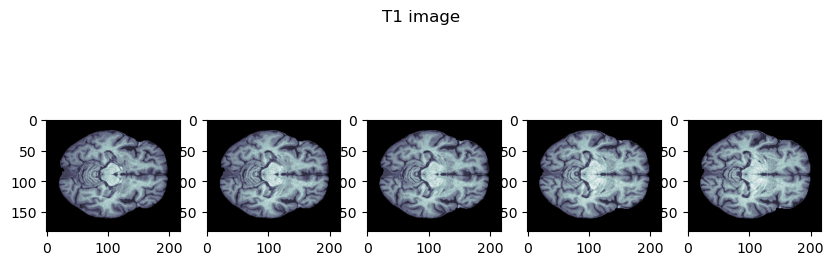

(182, 218, 182)


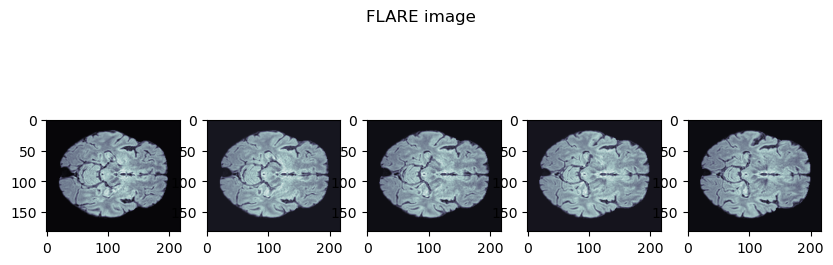

In [50]:
T1_img = nib.load(T1).dataobj
print(T1_img.shape)

for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(T1_img[:,:,59 + i], cmap='bone')
    plt.gcf().set_size_inches(10, 10)
plt.suptitle("T1 image")
plt.show()
FLARE_img = nib.load(FLARE).dataobj
print(FLARE_img.shape)

for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(FLARE_img[:,:,59 + i], cmap='bone')
    plt.gcf().set_size_inches(10, 10)
plt.suptitle("FLARE image")
plt.show()

[5273458  263699  404564  678086  535764   65045     344      37      29
       6]
[ -65.   229.4  523.8  818.2 1112.6 1407.  1701.4 1995.8 2290.2 2584.6
 2879. ]
-65.0 2879.0


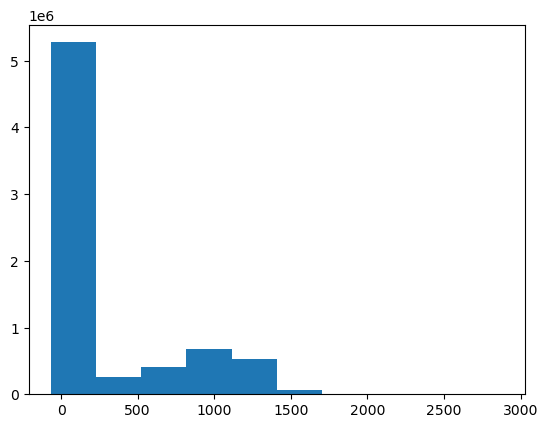

In [58]:
counts, bins = np.histogram(FLARE_img)
print(counts)
print(bins)
plt.hist(bins[:-1], bins, weights=counts)
print(np.min(T1_img), np.max(T1_img))

[5293539  153103  190509  924159  629020   29840     705     117      35
       5]
[-122.    54.9  231.8  408.7  585.6  762.5  939.4 1116.3 1293.2 1470.1
 1647. ]
-122.0 1647.0


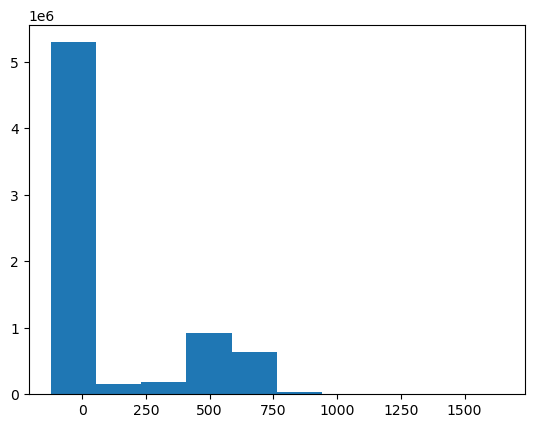

In [59]:
counts, bins = np.histogram(FLARE_img)
print(counts)
print(bins)
plt.hist(bins[:-1], bins, weights=counts)
print(np.min(FLARE_img), np.max(FLARE_img))

In [33]:
import torch
import torch.nn.functional as F
z_i = torch.randn(4, 128)
z_j = torch.randn(4, 128)
z = torch.cat([z_i, z_j], dim=0)
sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
print(sim)


tensor([[ 1.0000, -0.0498,  0.0888,  0.0085,  0.0441, -0.0459,  0.0328, -0.1302],
        [-0.0498,  1.0000, -0.1157, -0.0988, -0.0073, -0.0472, -0.0394,  0.0287],
        [ 0.0888, -0.1157,  1.0000,  0.0313,  0.0814, -0.0270,  0.1439,  0.0533],
        [ 0.0085, -0.0988,  0.0313,  1.0000, -0.1508,  0.1454, -0.1334, -0.0446],
        [ 0.0441, -0.0073,  0.0814, -0.1508,  1.0000,  0.0011, -0.0073,  0.0250],
        [-0.0459, -0.0472, -0.0270,  0.1454,  0.0011,  1.0000, -0.0280,  0.1664],
        [ 0.0328, -0.0394,  0.1439, -0.1334, -0.0073, -0.0280,  1.0000, -0.1420],
        [-0.1302,  0.0287,  0.0533, -0.0446,  0.0250,  0.1664, -0.1420,  1.0000]])


In [34]:
sim_ij = torch.diag(sim, 2)
sim_ji = torch.diag(sim, -2)
pos = torch.cat([sim_ij, sim_ji], dim=0)
nom = torch.exp(pos / 1)

In [35]:
#denom = self.neg_mask * torch.exp(sim / self.temp)
sim_ij.shape
sim_ij

tensor([ 0.0888, -0.0988,  0.0814,  0.1454, -0.0073,  0.1664])

In [36]:
sim_ji

tensor([ 0.0888, -0.0988,  0.0814,  0.1454, -0.0073,  0.1664])

In [31]:
pos.shape

torch.Size([12])